# OBJECTIVE: Build ML algorithm to use text-based clinical literature to classify genetic mutations.

In [44]:
%matplotlib inline

# Data wrapper libraries
import pandas as pd
pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

import numpy as np

# Visualization Libraries
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.markers import MarkerStyle
import seaborn as sns
color = sns.color_palette()

# Text analysis helper libraries
from gensim.summarization import summarize
from gensim.summarization import keywords

# Text analysis helper libraries for word frequency etc..
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from string import punctuation

from collections import Counter

# Word2Vec related libraries
from gensim.models import KeyedVectors

# Dimensionaly reduction libraries
from sklearn.decomposition import PCA

# Clustering library
from sklearn.cluster import KMeans

# Set figure size a bit bigger than default so everything is easily red
plt.rcParams["figure.figsize"] = (11, 7)


from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

import gensim

import scikitplot.plotters as skplt

import nltk

from xgboost import XGBClassifier

import os

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.optimizers import Adam

Using TensorFlow backend.


In [3]:
tr_txt = pd.read_csv("training_text/training_text", sep="\|\|", engine='python', header=None, skiprows=1, names=["ID","Text"])
test_txt = pd.read_csv("test_text/test_text", sep="\|\|", engine='python', header=None, skiprows=1, names=["ID","Text"])
tr_var = pd.read_csv("training_variants/training_variants")
test_var = pd.read_csv("test_variants/test_variants")

## EDA

In [4]:
tr_txt.head()

,ID,Text
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [5]:
#Get a taste of how huge text is attached to 0 ID genetic var
tr_txt['Text'].iloc[0]

"Cyclin-dependent kinases (CDKs) regulate a variety of fundamental cellular processes. CDK10 stands out as one of the last orphan CDKs for which no activating cyclin has been identified and no kinase activity revealed. Previous work has shown that CDK10 silencing increases ETS2 (v-ets erythroblastosis virus E26 oncogene homolog 2)-driven activation of the MAPK pathway, which confers tamoxifen resistance to breast cancer cells. The precise mechanisms by which CDK10 modulates ETS2 activity, and more generally the functions of CDK10, remain elusive. Here we demonstrate that CDK10 is a cyclin-dependent kinase by identifying cyclin M as an activating cyclin. Cyclin M, an orphan cyclin, is the product of FAM58A, whose mutations cause STAR syndrome, a human developmental anomaly whose features include toe syndactyly, telecanthus, and anogenital and renal malformations. We show that STAR syndrome-associated cyclin M mutants are unable to interact with CDK10. Cyclin M silencing phenocopies CDK1

It's huge!! There is a lot of literature to back up a decision on cancer or not, which is a good thing.

In [6]:
test_txt.head()

,ID,Text
0,0,2. This mutation resulted in a myeloproliferat...
1,1,Abstract The Large Tumor Suppressor 1 (LATS1)...
2,2,Vascular endothelial growth factor receptor (V...
3,3,Inflammatory myofibroblastic tumor (IMT) is a ...
4,4,Abstract Retinoblastoma is a pediatric retina...


In [7]:
#Let's see if the same amount of text is in test DF.
test_txt['Text'].iloc[0]

"2. This mutation resulted in a myeloproliferative phenotype, including erythrocytosis, in a murine model of retroviral bone marrow transplantation.  CONCLUSIONS  JAK2 exon 12 mutations define a distinctive myeloproliferative syndrome that affects patients who currently receive a diagnosis of polycythemia vera or idiopathic erythrocytosis.  The myeloproliferative disorders comprise a spectrum of chronic hematologic diseases that are likely to arise from a mutant multipotent hematopoietic stem cell.1,2 The V617F somatic mutation in the Janus kinase (JAK) 2 gene (JAK2), which causes the substitution of phenylalanine for valine at position 617, has recently been found in the majority of patients with polycythemia vera and in many with essential thrombocythemia or idiopathic myelofibrosis.3-7 This gene encodes a cytoplasmic tyrosine kinase. The mutation, which occurs in the JAK homology 2 (JH2) negative regulatory domain, increases JAK2 kinase activity and causes cytokine-independent growt

In [8]:
tr_var.head()

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [9]:
test_var.head()

,ID,Gene,Variation
0,0,ACSL4,R570S
1,1,NAGLU,P521L
2,2,PAH,L333F
3,3,ING1,A148D
4,4,TMEM216,G77A


test_var is missing class column which is what the purpose of this analysis is to figure out.

In [10]:
tr_txt.shape, test_txt.shape, tr_var.shape, test_var.shape

((3321, 2), (5668, 2), (3321, 4), (5668, 3))

Test dataset is far larger than training dataset.

Now let us look at overall gene distribution in the Training dataset.

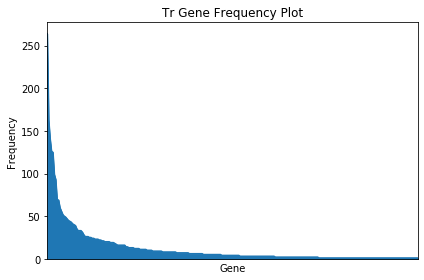

In [11]:
plt.figure()
ax = tr_var['Gene'].value_counts().plot(kind='area')

ax.get_xaxis().set_ticks([])
ax.set_title('Tr Gene Frequency Plot')
ax.set_xlabel('Gene')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

Compared to test_var:

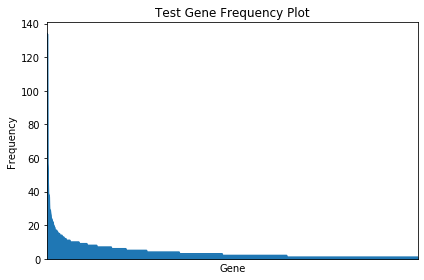

In [12]:
plt.figure()
ax = test_var['Gene'].value_counts().plot(kind='area')

ax.get_xaxis().set_ticks([])
ax.set_title('Test Gene Frequency Plot')
ax.set_xlabel('Gene')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

There are not as many clearly dominant genes in the Test dataset as seen in Trending dataset.

Now, breaking down Trending dataset's gene distribution across classes.

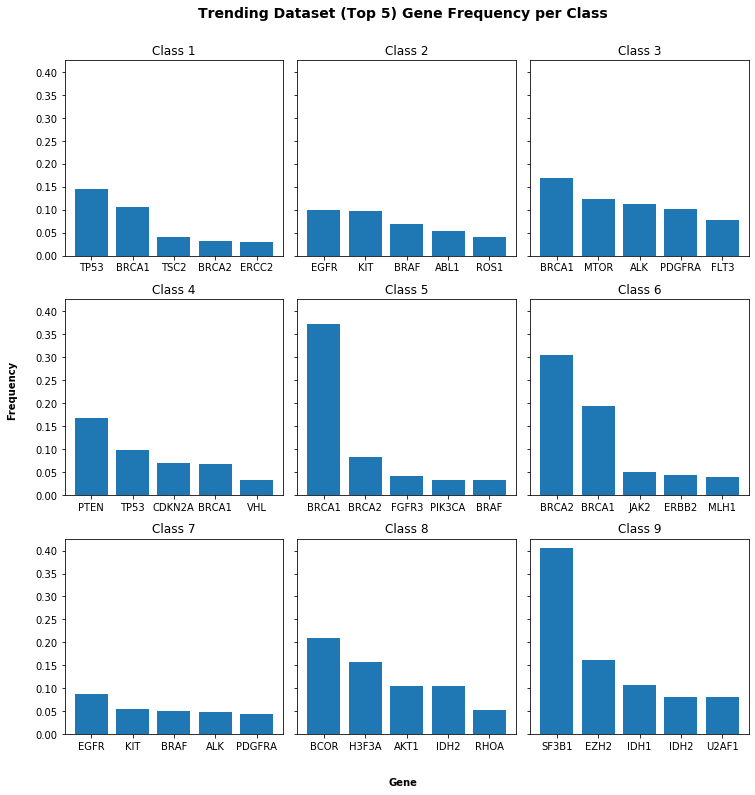

In [13]:
fig, axes = plt.subplots(nrows=3, ncols=3, sharey=True, figsize=(11,11))

# Normalize value counts for better comparison
def normalize_group(x):
    label, repetition = x.index, x
    t = sum(repetition)
    r = [n/t for n in repetition]
    return label, r

for idx, g in enumerate(tr_var.groupby('Class')):
    label, val = normalize_group(g[1]["Gene"].value_counts())
    ax = axes.flat[idx]
    ax.bar(np.arange(5), val[:5],
           tick_label=label[:5]) 
    ax.set_title("Class {}".format(g[0]))
    
fig.text(0.5, 0.97, 'Trending Dataset (Top 5) Gene Frequency per Class', ha='center', fontsize=14, fontweight='bold')
fig.text(0.5, 0, 'Gene', ha='center', fontweight='bold')
fig.text(0, 0.5, 'Frequency', va='center', rotation='vertical', fontweight='bold')
fig.tight_layout(rect=[0.03, 0.03, 0.95, 0.95])

In the Training dataset, there are genes in some classes that are dominant dwarfing all other genes in the depicted class. This includes Class 5, 6 and 9. Also, another thing to note is BRCA1 and BRCA2 genes appear the most frequently from class to class. Though this is interesting, this feature will be dropped as well for Class prediction.

Gene column distribution from earlier in the notebook is highly skewed. 
Though this can be valuable if it is normalized and balanced by weights. However, in order to not over complicate things for now, this column will be disregarded as well for text analysis.

Let's take a look at the Trending dataset's Variation column's descriptive statistics.

In [14]:
tr_var['Variation'].describe()

count                     3321
unique                    2996
top       Truncating Mutations
freq                        93
Name: Variation, dtype: object

There are 2996 unique protein Variations. This means most of them are unique though not very useful for predictions. So this column will be dropped. 

Let's look at class distributions and see if there are huge class imbalances. This will affect the accuracy of our prediction classifier.

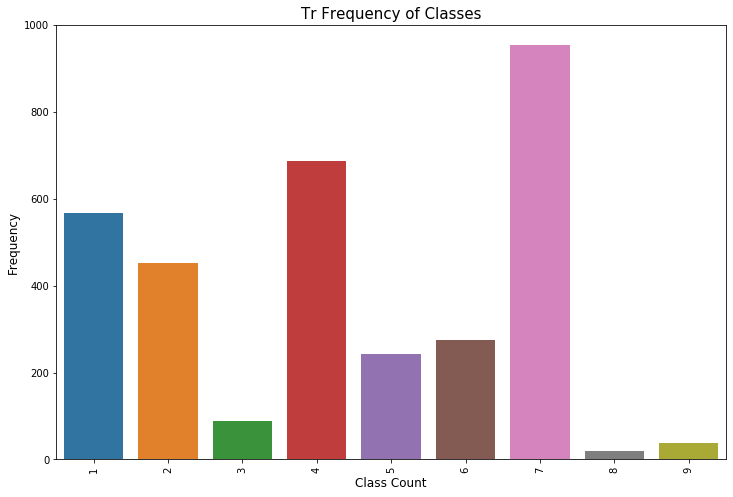

In [15]:
plt.figure(figsize=(12,8))
sns.countplot(x="Class", data=tr_var)
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Class Count', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Tr Frequency of Classes", fontsize=15)
plt.show()

There is class imbalance. Classes 4 and 7 are the most represented. Whereas classes 3, 8 and 9 are the most under-represented. This can be solved with bias weights, carefully sampling batches or removing dominant data to equalize the field.

No comparison to test dataset is possible since there are no classes given since the objective of the analysis is to predict them using the test dataset.

Now checking for NaN's that would affect subsequent analysis.

In [16]:
tr_txt.isnull().sum(), tr_var.isnull().sum(), test_txt.isnull().sum(), test_var.isnull().sum()

(ID      0
 Text    5
 dtype: int64, ID           0
 Gene         0
 Variation    0
 Class        0
 dtype: int64, ID      0
 Text    1
 dtype: int64, ID           0
 Gene         0
 Variation    0
 dtype: int64)

There are 5 in tr_text DF and 1 in test_txt DF. Let us locate them to get some context.

In [17]:
nans = lambda df: df[df.isnull().any(axis=1)]
nans(tr_txt)

,ID,Text
1109,1109,NaN
1277,1277,NaN
1407,1407,NaN
1639,1639,NaN
2755,2755,NaN


In [18]:
nans(test_txt)

,ID,Text
1623,1623,NaN


Need to keep in mind ID's 1109, 1277, 1407, 1639 and 2755 in tr_txt and ID 1623 in test_txt when using any math function for analysis. Will need to completely eliminate these from datasets to prevent run barriers.

In [56]:
tr_txt.fillna(0, inplace=True), test_txt.fillna(0, inplace=True)

(None, None)

In [57]:
tr_txt.isnull().sum(), test_txt.isnull().sum()

(ID      0
 Text    0
 dtype: int64, ID      0
 Text    0
 dtype: int64)

Before analyzing more of the data, e.g. heading into text analysis, let's drop the Gene and Variation columns.

In [19]:
tr_var.head()

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [20]:
tr_var.drop(['Gene', 'Variation'], axis=1, inplace=True)

# Additionaly we will drop the null labeled texts too (in Trending and Test dataset)
tr_txt = tr_txt[tr_txt['Text'] != 'null']
test_txt = test_txt[test_txt['Text'] != 'null']

Now, let us handle the text data and see what sort of insights we can draw from it in order to help in our prediction algorithm. In order to first start doing this, need to first combine the training text DF to the training variant DF. Let's start!

In [58]:
tr_data = pd.concat([tr_var, tr_txt], axis=1)
tr_data.head()

,ID,Class,ID,Text
0,0,1,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,2,1,Abstract Background Non-small cell lung canc...
2,2,2,2,Abstract Background Non-small cell lung canc...
3,3,3,3,Recent evidence has demonstrated that acquired...
4,4,4,4,Oncogenic mutations in the monomeric Casitas B...


Let's take a look at the text again with some keywords and post-text processing on a sample of data only for now using gensim's TextRank algorithm.

In [22]:
t_id = 0
text = tr_data.loc[t_id, 'Text']

word_scores = keywords(text, words=5, scores=True, split=True, lemmatize=True)
#word_scores = ', '.join(['{}-{:.2f}'.format(k, s[0]) for k, s in word_scores])
summary = summarize(text, word_count=100)

print('ID [{}]\nKeywords: [{}]\nSummary: [{}]'.format(t_id, word_scores, summary))

ID [0]
Keywords: [[('cdk', 0.3934447412907815), ('cell', 0.22309997351577512), ('ets', 0.21293157336651014), ('proteins', 0.21103648629359192), ('gene', 0.17081930053896233)]]
Summary: [CDK10 knockdown derepresses ETS2, which increases the expression of the c-Raf protein kinase, activates the MAPK pathway, and induces resistance of MCF7 cells to tamoxifen (6).Here, we deorphanize CDK10 by identifying cyclin M, the product of FAM58A, as a binding partner.
Finally, we detect an increased ETS2 expression level in cells derived from a STAR patient, and we demonstrate that it is attributable to the decreased cyclin M expression level observed in these cells.Previous SectionNext SectionResultsA yeast two-hybrid (Y2H) screen unveiled an interaction signal between CDK10 and a mouse protein whose C-terminal half presents a strong sequence homology with the human FAM58A gene product [whose proposed name is cyclin M (11)].]


After text is tokenized (strings split into words), cleaned of stop words as well as lemmatized, we can see key words are: cell, ets, proteins and gene. 

Now, will tokenize, remove stop words as well as lemmatize the text for word frequency analysis. 

In [25]:
custom_words = ["fig", "figure", "et", "al", "al.", "also",
                "data", "analyze", "study", "table", "using",
                "method", "result", "conclusion", "author", 
                "find", "found", "show", '"', "’", "“", "”"]

stop_words = set(stopwords.words('english') + list(punctuation) + custom_words)
wordnet_lemmatizer = WordNetLemmatizer()

class_corpus = tr_data.groupby('Class').apply(lambda x: x['Text'].str.cat())
class_corpus = class_corpus.apply(lambda x: Counter(
    [wordnet_lemmatizer.lemmatize(w) 
     for w in word_tokenize(x) 
     if w.lower() not in stop_words and not w.isdigit()]
))

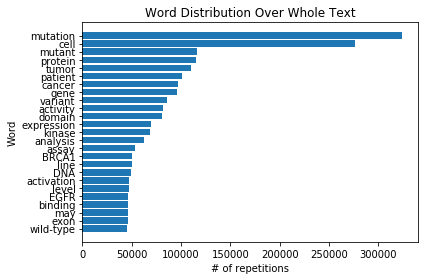

In [27]:
whole_text_freq = class_corpus.sum()

fig, ax = plt.subplots()

label, repetition = zip(*whole_text_freq.most_common(25))

ax.barh(range(len(label)), repetition, align='center')
ax.set_yticks(np.arange(len(label)))
ax.set_yticklabels(label)
ax.invert_yaxis()

ax.set_title('Word Distribution Over Whole Text')
ax.set_xlabel('# of repetitions')
ax.set_ylabel('Word')

plt.tight_layout()
plt.show()

Mutation, cell, mutant, protein, tumor, patient, cancer and gene are the top words from the whole text corpus. 

We will now work on establishing features from text to build ML classifer that will use text to predict class mutation.

Let us first define a helper function 

In [45]:
def evaluate_features(X, y, clf=None):
    """General helper function for evaluating effectiveness of passed features in ML model
    
    Prints out Log loss, accuracy, and confusion matrix with 3-fold stratified cross-validation
    
    Args:
        X (array-like): Features array. Shape (n_samples, n_features)
        
        y (array-like): Labels array. Shape (n_samples,)
        
        clf: Classifier to use. If None, default Log reg is use.
    """
    if clf is None:
        clf = LogisticRegression()
    
    probas = cross_val_predict(clf, X, y, cv=StratifiedKFold(random_state=8), 
                              n_jobs=-1, method='predict_proba', verbose=2)
    pred_indices = np.argmax(probas, axis=1)
    classes = np.unique(y)
    preds = classes[pred_indices]
    print('Log loss: {}'.format(log_loss(y, probas)))
    print('Accuracy: {}'.format(accuracy_score(y, preds)))
    skplt.plot_confusion_matrix(y, preds)

quickly testing evaluate_features:

C:\Users\mindy\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:629: FutureWarning: The default value of n_split will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(NSPLIT_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.2s finished
C:\Users\mindy\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:85: DeprecationWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=DeprecationWarning)


Log loss: 0.34456225154048314
Accuracy: 0.9466666666666667


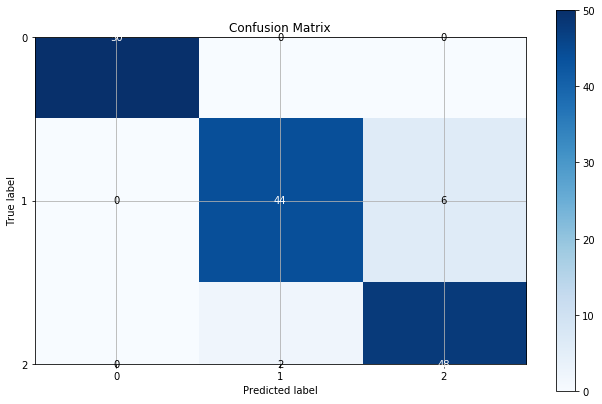

In [46]:
from sklearn.datasets import load_iris
evaluate_features(*load_iris(True))

Pretty good output since accuracy is high while log loss is on the low end.

Now, let's start with a baseline: Bag of Words

In [47]:
count_vectorizer = CountVectorizer(
    analyzer="word", tokenizer=nltk.word_tokenize,
    preprocessor=None, stop_words='english', max_features=None)

In [60]:
#bag_of_words = count_vectorizer.fit_transform(tr_data['Text'])

In [ ]:
#len(count_vectorizer.get_feature_names())

There are unique words in the corpus.